In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.sql.expression import and_

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create inspector
inspector = inspect(engine)

In [9]:
# Inspect columns for Measurement
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Inspect columns for Station
columns = inspector.get_columns('Station')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [12]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [13]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
result = calc_temps('2016-01-01', '2016-12-31')
print(result)

[(56.0, 74.14421827631008, 84.0)]


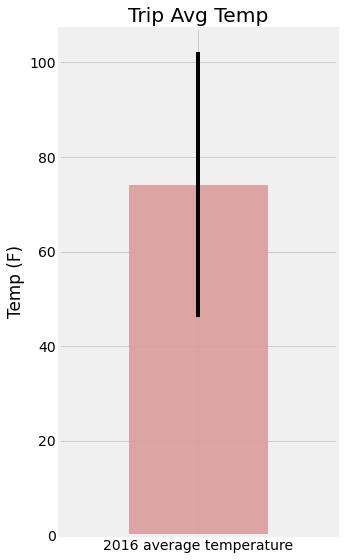

In [14]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
result_df = pd.DataFrame(result, columns = ['TMIN', "TAVE",'TMAX'])
avg_temp = result_df['TAVE']
yerr = result_df['TMAX'] - result_df['TMIN']

plt.figure(facecolor=(1,1,1))
plt.ylabel('Temp (F)')
avg_temp.plot(kind='bar', yerr = yerr, figsize =(5,8), grid = True, color='#DB9C9C',alpha = 0.9, title = 'Trip Avg Temp')
plt.xticks(np.arange(len(avg_temp)),["2016 average temperature"], rotation = 0)
plt.tight_layout()
plt.savefig("../Images/Trip_avg_temp.png")

plt.show()

### Daily Rainfall Average

In [15]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
end_Date = '2016-12-31'

# Convert end_Date to be used for datatime
year = int(end_Date[:4])
month = int(end_Date[5:7])
day = int(end_Date[8:])

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(year, month, day)

# Calculate the date one year from the last date in data set.
query_date_1year = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the station and precipitation scores
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
prcp_data = session.query(*sel).filter(Station.station == Measurement.station).\
    filter(and_(Measurement.date >= query_date_1year, Measurement.date <= recent_date)).\
    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

In [16]:
# Save the query results as a Pandas DataFrame
prcp_df = pd.DataFrame(prcp_data, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
prcp_df

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,162.88
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,79.89
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,52.15
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,30.77
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,27.29
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.15
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.97


### Daily Temperature Normals

In [17]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [18]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
travel_dates = []
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates

# Strip off the year and save a list of strings in the format %m-%d
start_date_obj = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date_obj = dt.datetime.strptime(end_date, '%Y-%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.\
while (start_date_obj <= end_date_obj):
    travel_dates.append(dt.datetime.strftime(start_date_obj, '%m-%d'))
    normals.append(list(np.ravel(daily_normals(dt.datetime.strftime(start_date_obj, '%m-%d')))))
    start_date_obj = start_date_obj + dt.timedelta(days=1)

In [19]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
week_travel_tem = pd.DataFrame(normals, columns=['TMIN','TAVE','TMAX'])
week_travel_tem['Date'] = travel_dates
week_travel_tem = week_travel_tem.set_index('Date')
week_travel_tem

,TMIN,TAVE,TMAX
Date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


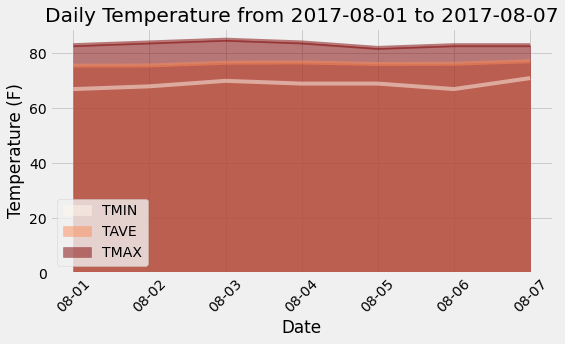

In [20]:
# Plot the daily normals as an area plot with `stacked=False`
week_travel_tem.plot.area(stacked = False, ylabel='Temperature (F)',xlabel='Date', title=f"Daily Temperature from {start_date} to {end_date}", figsize=(8,5), rot = 45, colormap = 'OrRd')
plt.tight_layout()
plt.savefig(f'../Images/Daily_Temperature_from_{start_date}_to_{end_date}')

plt.show()


## Close Session

In [21]:
session.close()